# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 26.4 MB 64 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
923,1,41.0,32300.0,2,0
2933,0,25.0,48800.0,1,0
4186,1,25.0,50600.0,1,0
177,1,56.0,56000.0,0,3
92,1,25.0,26700.0,1,0
4454,1,32.0,20100.0,1,0
889,1,33.0,28000.0,2,0
3211,0,31.0,40100.0,0,0
894,0,40.0,28100.0,0,0
4769,1,20.0,58500.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:

df['age'] = df['age'].astype('int')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


The descriptive statistics appear to make sense, with age, income, gender, and number of family members all appearing to make logical sense.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

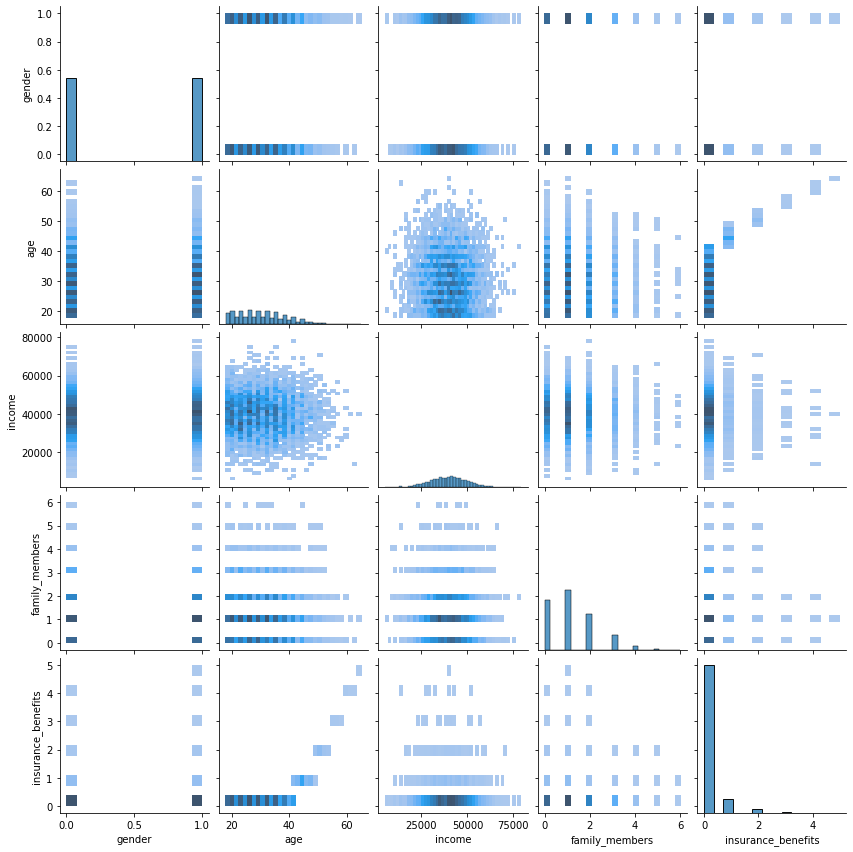

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

We will write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

We will answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors = k, metric = metric)
    nbrs.fit(df[feature_names],df['insurance_benefits'])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

For displaying the k-nearest neighbors, we can test by taking an arbitrary point. We will look for the 10 nearest neighbors (which will require setting k to 11 since our function will return the exact point as one of the neighbors).

In [14]:
# display euclidean distance with unscaled data

get_knn(df, 4649, 11, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
4649,1,31,46900.0,2,0,0.000000
725,0,29,46900.0,1,0,2.449490
1262,0,30,46900.0,0,0,2.449490
868,0,36,46900.0,2,0,5.099020
2364,1,26,46900.0,3,0,5.099020
3407,0,25,46900.0,3,0,6.164414
4077,1,23,46900.0,0,0,8.246211
2912,1,42,46900.0,0,1,11.180340
886,0,18,46900.0,1,0,13.076697
1503,1,32,46800.0,3,0,100.010000


In [15]:
# manhattan distance for the same point

get_knn(df, 4649, 11, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
4649,1,31,46900.0,2,0,0.0
725,0,29,46900.0,1,0,4.0
1262,0,30,46900.0,0,0,4.0
2364,1,26,46900.0,3,0,6.0
868,0,36,46900.0,2,0,6.0
3407,0,25,46900.0,3,0,8.0
4077,1,23,46900.0,0,0,10.0
2912,1,42,46900.0,0,1,13.0
886,0,18,46900.0,1,0,15.0
1503,1,32,46800.0,3,0,102.0


Scaling the data.

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1930,1.0,0.292308,0.570886,0.166667,0
2628,0.0,0.630769,0.575949,0.000000,0
3428,1.0,0.384615,0.694937,0.000000,0
792,1.0,0.584615,0.483544,0.166667,0
2984,1.0,0.507692,0.354430,0.166667,0


Now, let's get similar records for a given one for every combination

In [18]:
get_knn(df_scaled, 4649, 11, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
4649,1.0,0.476923,0.593671,0.333333,0,0.000000
1620,1.0,0.476923,0.605063,0.333333,0,0.011392
2556,1.0,0.492308,0.589873,0.333333,0,0.015846
2566,1.0,0.461538,0.589873,0.333333,0,0.015846
434,1.0,0.492308,0.608861,0.333333,0,0.021620
4870,1.0,0.476923,0.622785,0.333333,0,0.029114
4577,1.0,0.476923,0.564557,0.333333,0,0.029114
1804,1.0,0.507692,0.591139,0.333333,0,0.030873
2646,1.0,0.507692,0.601266,0.333333,0,0.031693
1395,1.0,0.492308,0.563291,0.333333,0,0.034053


In [19]:
get_knn(df_scaled, 4649, 11, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
4649,1.0,0.476923,0.593671,0.333333,0,0.000000
1620,1.0,0.476923,0.605063,0.333333,0,0.011392
2556,1.0,0.492308,0.589873,0.333333,0,0.019182
2566,1.0,0.461538,0.589873,0.333333,0,0.019182
4870,1.0,0.476923,0.622785,0.333333,0,0.029114
4577,1.0,0.476923,0.564557,0.333333,0,0.029114
434,1.0,0.492308,0.608861,0.333333,0,0.030574
1804,1.0,0.507692,0.591139,0.333333,0,0.033301
2646,1.0,0.507692,0.601266,0.333333,0,0.038364
1395,1.0,0.492308,0.563291,0.333333,0,0.045764


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

After scaling the data, we see that the K-nearest neighbors does result in different values being identified as the nearest neighbors. The relative distance we see has not just been scaled but it has, in fact, become quite a bit smaller. We can see that in the unscaled algorithm, we have values that are factors of ten farther away whereas for the scaled version, all the units are within the same factor.

This would mean that after scaling the data, not only are we getting different points but the ones we are identify are closer together not only on an absolute level but also relatively.

It seems that for the nearest neighbors that the number of benefits is the strongest correlation but that is also a result of most of the values being 0. The same goes for family members, which we see in the scaled data has a uniform 0.33 result. Interestingly, after scaling the data we see that the nearest neighbors all end up sharing the same gender as the original value, which might be a result of the data points all being closer together. Also, there are fewer unique values in those factors in the data overall, so they are more arbitrary. Since both of those have very few different observations, though, they likely are not the primarily important parameter, in particular because both could also be dependent on the other two predictors - income and age.

Income appears to be the strongest factor overall, with it on the unscaled data being identical for all of the 10 nearest neighbors. Age is the next strongest.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Regardless of the scaling, it appears that the Manhattan distance returns mostly the same points as the Euclidean. The only time there is a difference is that the 10th nearest neighbor is different for the scaled data, and also that in the scaled data the order of some of the neighbors (specifically point 434, 4870, and 4577) are different.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, we will evaluate whether the kNN classification approach can do better than a dummy model.

Procedures:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

We will split the whole data in the 70:30 proportion for the training/testing parts.

In [21]:
# calculate the target

# create column for # of clients who received insurance benefits

df['insurance_benefits_received'] = df['insurance_benefits'] >= 1

# convert that column to numeric

df['insurance_benefits_received'] = df['insurance_benefits_received'].astype('int')

# repeat for the scaled data frame

df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] >= 1
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits_received'].astype('int')

In [22]:
df

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
...,...,...,...,...,...,...
4995,0,28,35700.0,2,0,0
4996,0,34,52400.0,1,0,0
4997,0,20,33900.0,2,0,0
4998,1,22,32700.0,3,0,0


In [21]:
# check for the class imbalance with value_counts()

print(df['insurance_benefits_received'].value_counts())
print()
print(df['insurance_benefits_received'].value_counts(normalize=True))

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64


Since the data is unbalanced with most of our targets being = 0, we can use the stratify parameter when splitting our training and test set.

In [29]:
# split into features and target

features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']

# split into training and test set

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size = 0.3, random_state = 12345, 
                                                                            stratify = target)

# check the shape of the data

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3500, 4) (3500,)
(1500, 4) (1500,)


In [30]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [31]:
# generating output of a random model

def rnd_model_predict(P, size, seed = 12345):

    rng = np.random.default_rng(seed = seed)
    return rng.binomial(n=1, p=P, size=size)

In [32]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, features.shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.793  0.0942]
 [0.0992 0.0136]]

The probability: 0.50
F1: 0.18
Confusion Matrix
[[0.4516 0.4356]
 [0.0584 0.0544]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



The RNG model gives us these confusion matrices. The highest accuracy model is the one where it assumes that none of the customers recieved an insurance benefit (which is necessary for an insurance company to sustain itself) but that means that we can likely make a model that is rather accurate if we take into account our data.

### Test with KNN

In [33]:
f1_score = []

for k in range(1, 11):
    k_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k, radius = 0.4)
    k_classifier.fit(features_train, target_train)
    prediction = k_classifier.predict(features_test)
    f1 = sklearn.metrics.f1_score(target_test, prediction)
    f1_score.append(f1)
    print(f'Neighbors: {k} \n F1: {f1:.4f}\n')

Neighbors: 1 
 F1: 0.5852

Neighbors: 2 
 F1: 0.3927

Neighbors: 3 
 F1: 0.3966

Neighbors: 4 
 F1: 0.1579

Neighbors: 5 
 F1: 0.1538

Neighbors: 6 
 F1: 0.0575

Neighbors: 7 
 F1: 0.0682

Neighbors: 8 
 F1: 0.0462

Neighbors: 9 
 F1: 0.0462

Neighbors: 10 
 F1: 0.0000



In [34]:
# scale the features values

scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [35]:
f1_scaled = []

for k in range(1, 11):
    k_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k, radius = 0.4)
    k_classifier.fit(features_train_scaled, target_train)
    prediction = k_classifier.predict(features_test_scaled)
    f1 = sklearn.metrics.f1_score(target_test, prediction)
    f1_scaled.append(f1)
    print(f'Neighbors: {k} \n F1: {f1:.4f}\n')

Neighbors: 1 
 F1: 0.9583

Neighbors: 2 
 F1: 0.9313

Neighbors: 3 
 F1: 0.9521

Neighbors: 4 
 F1: 0.9010

Neighbors: 5 
 F1: 0.9113

Neighbors: 6 
 F1: 0.9003

Neighbors: 7 
 F1: 0.9091

Neighbors: 8 
 F1: 0.8939

Neighbors: 9 
 F1: 0.9063

Neighbors: 10 
 F1: 0.9051



These numbers are good to have, but it will be easier to see the F1 scores if they are plotted.

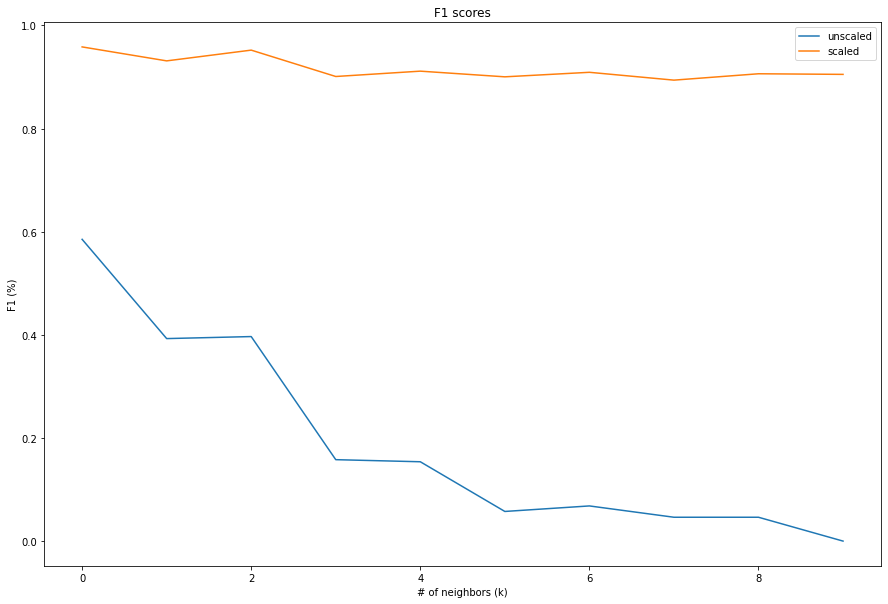

In [36]:
# plot 

plt.figure(figsize=(15,10))
plt.plot(f1_score, label = 'unscaled')
plt.plot(f1_scaled, label = 'scaled')
plt.title('F1 scores')
plt.xlabel('# of neighbors (k)')
plt.ylabel('F1 (%)')
plt.legend()
plt.show()

We see that with our F1 score that we get fairly consistently good results with our scaled model, but with the unscaled model the F1 score drops steeply as we add more neighbors. In this case, regardless of what we choose to use for k, it seems like the scaled model is the more accurate option.

Since the dummy model would have a high accuracy of 0.8872 by simply guessing 0 for all values, getting a better model would be rather tricky. Our scaled model manages to surpass that accuracy, going as high as having an F1 score of 0.9659.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [37]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis = 1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [38]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [39]:
# features and target split

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# checking linear regression

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [40]:
# features and target split

X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

# train test split

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, 
                                                                                test_size=0.3, random_state=12345)

# checking linear regression

lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train_scaled)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred_scaled)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


What we see here is that whether or not we scale the data, the same RMSE is achieved. From the weights, we see that the numbers of our weights different. The scaled model is far easier to deal with, as the numbers are more consistent whereas the unscaled model has numbers as small as e-07 level which is not as intuitive.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [44]:
# display P

P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [38]:
P_inv = np.linalg.inv(P)
P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can you guess the customers' ages or income after the transformation?

In [39]:
print('X\' = X * P:')
obs_data = X.dot(P)
obs_data

X' = X * P:


array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

These numbers might, in theory, be considered possible incomes as many we see in the sample do seem to align with income. However, that is simply conjecture and we see that while there are many that are in the 20,000-50,000 range (which is where most of our data lies) the ones that are under 10,000 show that this data does not reflect the age or income of the customers.

In brief, the data has been obfuscated.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$$
X' = X \times P \Rightarrow X' \times P^{-1} = X \times P \times P^{-1}
\Rightarrow X' \times P^{-1} = X
$$


In [40]:
return_X = obs_data.dot(np.linalg.inv(P))
return_X

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
print('Original:\n', X, '\n')
print('Transformed:\n', obs_data, '\n')
print('Recovered:\n', return_X)

Original:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]] 

Transformed:
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]] 

Recovered:
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

We can see that there are data points in the recovered data that are different, that tend to be aligned with the points in the original data where we saw points of 0. These points are all very close to 0, but are not equal to zero. The reason is simply an error in precision from convering from zero to a nonzero number and then back to what should result in zero.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$$\quad w_P = [(XP)^T XP]^{-1} (XP)^T y$$

$$\Rightarrow [(P^T X^T) XP]^{-1} P^TX^Ty$$

$$\Rightarrow [(P^T X^T X)P]^{-1} P^TX^Ty$$

$$\Rightarrow P^{-1}[P^T (X^T X)]^{-1} P^TX^Ty$$

$$\Rightarrow P^{-1}(X^T X)^{-1}(P^T)^{-1} P^TX^Ty$$

$$\Rightarrow P^{-1}(X^TX)^{-1}X^Ty$$

$$\textbf{recall } w = (X^TX)^{-1}X^Ty$$

$$w_P = P^{-1}w$$

The proof that $w_P = P^{-1}w$ is done such to prove that the predictions we get from the obfuscated data set will be the same as the predictions made in the original data. If this were not the case, then the predictions would be different which would be troubling as it would mean that the obfuscated data is not practical to use.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values.

In [42]:
# gather data

personal_info_column_list = ['gender', 'age', 'income', 'family_members']

X = df[personal_info_column_list].to_numpy()
y = df['insurance_benefits'].to_numpy()

In [43]:
# generate the random matrix P

rand = np.random.default_rng(seed = 12345)
P = rand.random(size=(X.shape[1], X.shape[1]))

In [44]:
# check for invertibility

P_inv = np.linalg.inv(P)
P_inv

array([[-1.97240014,  1.76004024, -0.08309671,  1.22285233],
       [ 0.14111106,  0.32873452,  1.02824721, -1.27752175],
       [ 0.8908452 ,  0.90302415, -0.59501472, -0.23290483],
       [ 1.02530945, -1.81039816,  0.24787878,  0.46192295]])

In [45]:
# perform linear regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

lin_reg = MyLinearRegression()

lin_reg.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lin_reg.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [46]:
# check on the obfuscated matrix

X_obs = X.dot(P)

X_train_obs, X_test_obs, y_train_obs, y_test_obs = train_test_split(X_obs, y, test_size = 0.3, random_state = 12345)

lin_reg_obs = MyLinearRegression()

lin_reg_obs.fit(X_train_obs, y_train_obs)
print(lr.weights)

y_test_pred_obs = lin_reg_obs.predict(X_test_obs)
eval_regressor(y_test_obs, y_test_pred_obs)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


Both of our linear regressions on the data, whether obfuscated or not, return the same weights and the same levels of error. This shows tangibly that the obfuscation does not alter the model's quality.

# Conclusions

For the first task, we created a model that tracks which customers are most similar to one another in terms of their gender, age, income, family size, and number of insurance benefits. We have found that after scaling our values we receive a more accurate means of identifying similar customers.

The second task held a more difficult hurdle of predicting if a customer would or would not receive insurance benefits. Since most customers do not receive benefits, it was seen that a dummy model that simply guesses 0 for all values performs rather well. However, we were able to create a model with a higher F1 score to be used for highly accurate predictions.

Thirdly, we predicted the number of benefits that a given customer was likely to receive by creating a model. This sort of work is vital in order to determine a pricing plan as well as when dealing on an individual basis. Related to this task, we obfuscated the data with a random number generator in order to protect the client's personal data and proved that this obfuscation process does not change the predictive model's results.